In [1]:
import seaborn as sns
import pandas as pd
import torch
import sys
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.distributions.normal import Normal
from torch.distributions.dirichlet import Dirichlet

$\Huge \text{Minimal Loss at Id. for Exchangeable Distribution}$


In [2]:
def compute_expec_loss_discrete_2D(z1, z2, p, theta, sigma):
    
    """
    Compute the expected loss conditioning on epsilon  in PyTorch.
    
    Args:
        Z_i_star (torch.Tensor): The Z_{i*} vector, shape (p,1).
        V (torch.Tensor): The V matrix, shape (p,p).
        sigma (float): The standard deviation (scalar).
        
    Returns:
        torch.Tensor: The loss and derivative of the loss with respect to V
    """

    normal = Normal(0, 1)
    theta = torch.tensor([theta * (np.pi) - (1/2 * np.pi)], dtype = torch.float32)
    cos_theta = torch.cos(theta)
    sin_theta = torch.sin(theta)
    V = torch.tensor([[cos_theta, -sin_theta],
                      [sin_theta,  cos_theta]])
    
    z1 = torch.Tensor(z1).view(2, 1)
    z2 = torch.Tensor(z2).view(2, 1)

    term_1 = -V @ z1 / sigma
    term_2 = -V @ z2 / sigma

    phi_1 = normal.log_prob(term_1).exp()
    phi_2 = normal.log_prob(term_2).exp()
    
    Phi_1 = normal.cdf(term_1)
    Phi_2 = normal.cdf(term_2)
    
    loss = torch.sum((phi_1 + term_1 * Phi_1) * sigma * p + (phi_2 + term_2 * Phi_2) * sigma * (1 - p)) 
    return loss
    

In [3]:
def plot_expected_loss_heatmap(z1, z2, sigma=0.2, grid_size=300, compute_func=compute_expec_loss_discrete_2D):
    """
    Plots a heatmap of the expected loss over a grid of (theta, p).

    Parameters:
    - z1, z2: 1D lists or arrays of length 2, representing discrete support points
    - sigma: float, standard deviation parameter for the loss
    - grid_size: int, resolution of the grid (default: 300)
    - compute_func: function handle, expects signature compute_func(z1, z2, p, theta, sigma)
    """
    assert compute_func is not None, "You must provide a compute_func that accepts (z1, z2, p, theta, sigma)."

    # Grid values
    theta_values = np.linspace(0, 1, grid_size)
    p_values = np.linspace(0, 1, grid_size)

    # Output matrix
    output_matrix = np.zeros((grid_size, grid_size))

    # Compute expected loss over grid
    for i, p in enumerate(p_values):
        for j, theta in enumerate(theta_values):
            result = compute_func(z1, z2, p, theta, sigma)
            output_matrix[(grid_size - i) - 1, j] = result.item()  # Flip vertically

    # Highlight row-wise minima and center lines
    highlight_matrix = np.zeros_like(output_matrix, dtype=bool)
    for row_idx, row in enumerate(output_matrix):
        min_col_idx = np.argmin(row)
        highlight_matrix[row_idx, min_col_idx] = True

    # Highlight central horizontal and vertical lines
    highlight_matrix[int(grid_size / 2), :] = True
    highlight_matrix[:, int(grid_size / 2)] = True

    # Plot heatmap
    plt.figure(figsize=(10, 8))
    
    # Base heatmap
    sns.heatmap(output_matrix,
                xticklabels=False,
                yticklabels=False,
                cmap='viridis',
                cbar_kws={'label': 'Expected Loss'})

    # Overlay highlight heatmap
    sns.heatmap(output_matrix,
                xticklabels=False,
                yticklabels=False,
                cmap='Reds',
                cbar=False,
                mask=~highlight_matrix,
                alpha=1)

    # Custom axis ticks
    plt.xticks([0, grid_size - 1], [r"$-\pi/2$", r"$\pi/2$"], fontsize=12)
    plt.yticks([grid_size - 1, 0], [0, 1], fontsize=12)

    # Labels and title
    plt.xlabel("θ (rotation angle)", fontsize=12)
    plt.ylabel("p (mixture weight)", fontsize=12)
    
    def fmt(z):
        return "[" + ", ".join(f"{v:.2f}" for v in z) + "]"
    plt.title(f"Heatmap of Expected Loss\nSupport: {fmt(z1)}, {fmt(z2)}", fontsize=14)
    plt.tight_layout()
    plt.show()

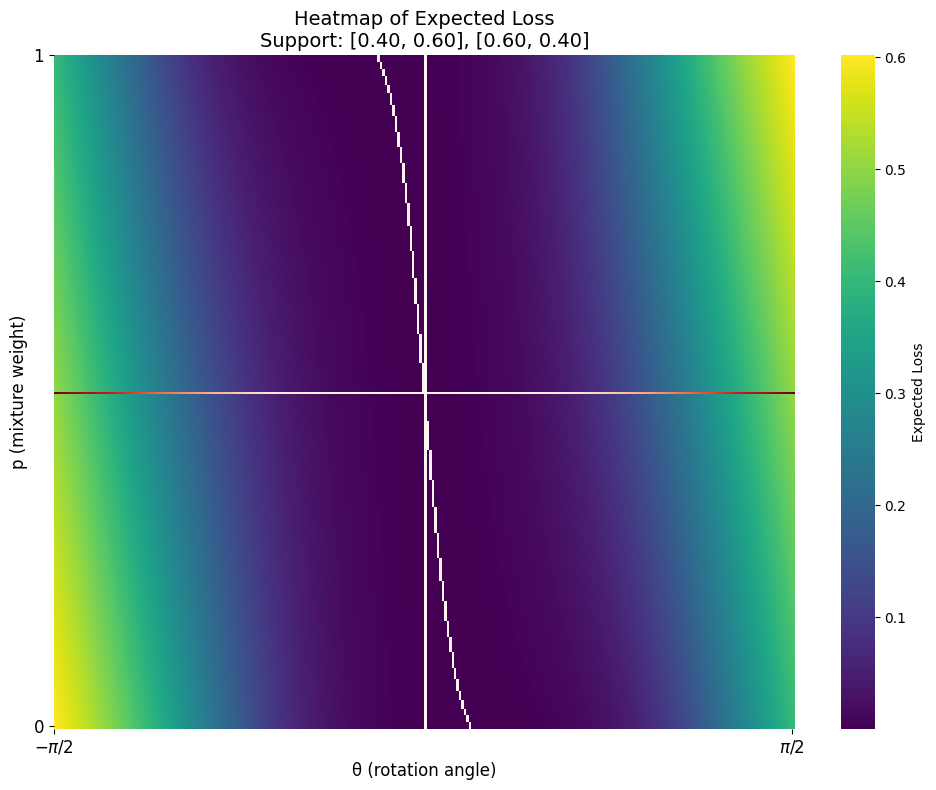

In [5]:
z1, z2, sigma = [0.4, 0.6], [0.6, 0.4], 0.2
grid_size = 300
plot_expected_loss_heatmap(z1, z2, sigma, grid_size)

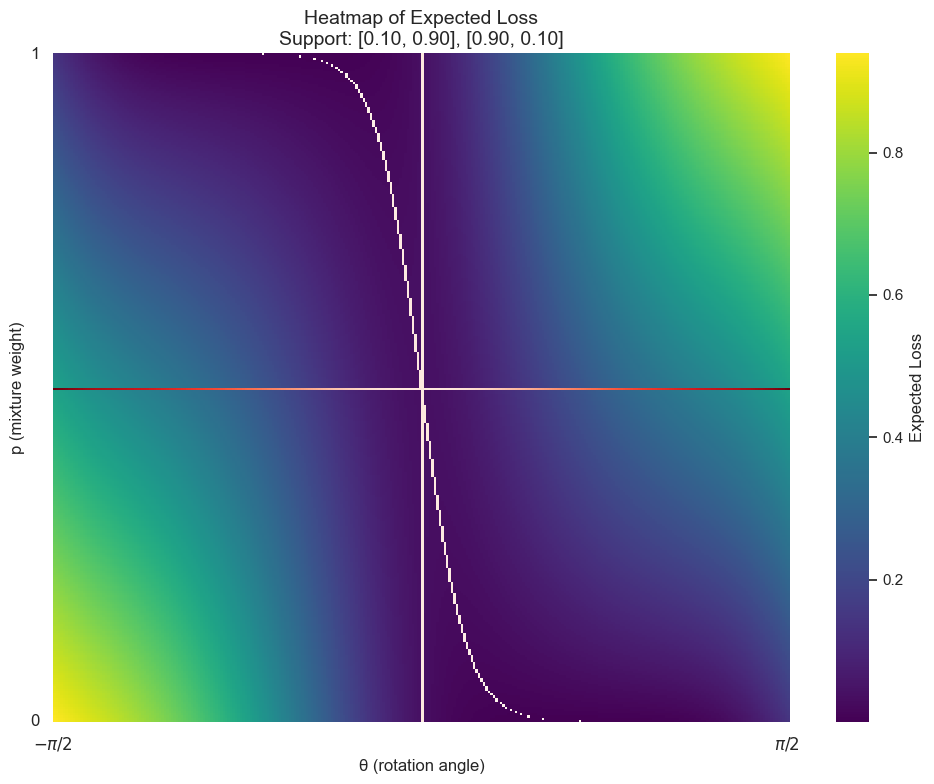

In [27]:
# Parameters
z1, z2, sigma = [0.1, 0.9], [0.9, 0.1], 0.2
grid_size = 300
plot_expected_loss_heatmap(z1, z2, sigma, grid_size)

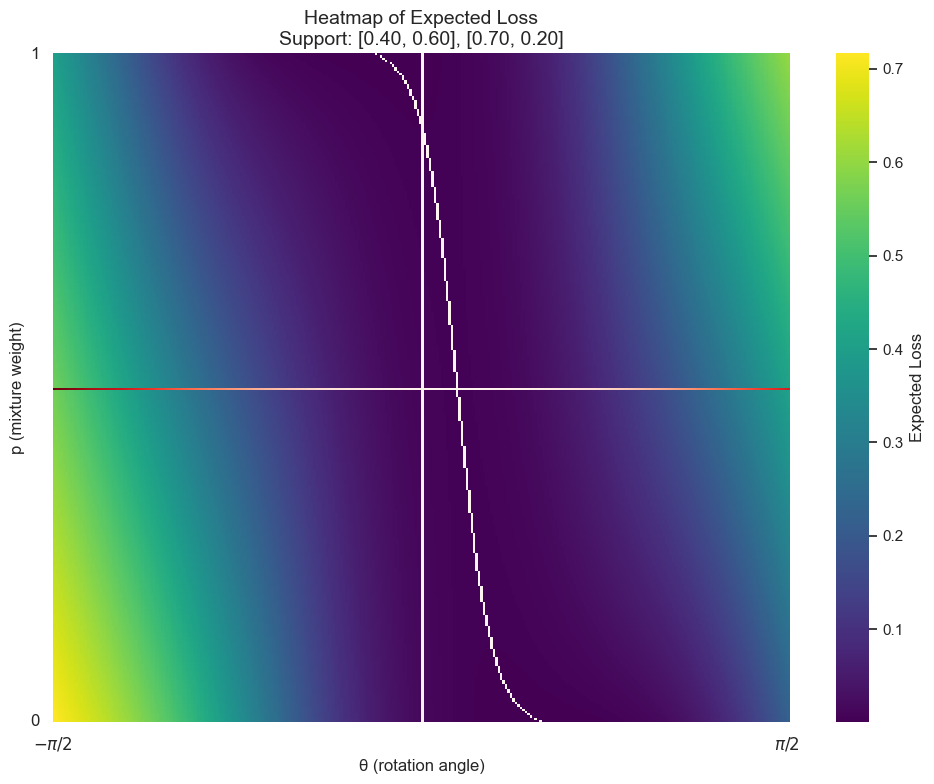

In [28]:
# Parameters
z1, z2, sigma = [0.4, 0.6], [0.7, 0.2], 0.2
grid_size = 300
plot_expected_loss_heatmap(z1, z2, sigma, grid_size)

$\Huge \text{`Efficiency' -- Optimum of the Gaussian Conditional ReLU Loss}$


In [ ]:
def find_most_covered_region_robust(lower_bounds, upper_bounds, margin_frac=0.01):
    """
    Robust method to find the y-region covered by the most confidence intervals.

    Parameters:
    - lower_bounds: array-like, CI lower bounds
    - upper_bounds: array-like, CI upper bounds
    - margin_frac: fraction of y-range to use as highlight region width

    Returns:
    - best_lower, best_upper: region most covered
    - max_count: number of intervals that cover it
    """
    all_bounds = np.concatenate([lower_bounds, upper_bounds])
    candidates = np.unique(np.sort(all_bounds))  # test only actual endpoints
    max_count = 0
    best_y = None

    for y in candidates:
        count = np.sum((lower_bounds <= y) & (upper_bounds >= y))
        if count > max_count:
            max_count = count
            best_y = y

    y_range = all_bounds.max() - all_bounds.min()
    margin = margin_frac * y_range

    return best_y - margin, best_y + margin, max_count



def plot_theta_var_ratio_with_ci(df,
                                 num_trials, 
                                 var_theta,
                                 var_theta_lb,
                                 var_theta_ub,
                                 hessian_theta_inv,
                                 n = 'n'):
    df = df.sort_values(n)

    n_vals = df[n]
    ratio = df[var_theta] / df[hessian_theta_inv]

    ratio_lb = df[var_theta_lb] / df[hessian_theta_inv]
    ratio_ub = df[var_theta_ub] / df[hessian_theta_inv]

    error_lower = ratio - ratio_lb
    error_upper = ratio_ub - ratio
    yerr = [error_lower.values, error_upper.values]

    # Highlight region most covered
    best_lower, best_upper, max_count = find_most_covered_region_robust(ratio_lb.values, ratio_ub.values)

    plt.figure(figsize=(10, 6))
    plt.errorbar(n_vals, ratio, yerr=yerr, fmt='o-', capsize=5,
                 label=r"$\mathrm{Var}(\hat\theta) / \mathrm{Hessian}^{-1}$")

    # Highlight region
    plt.axhspan(best_lower, best_upper, color='orange', alpha=0.2,
                label=f"Most covered region ({100*max_count/df.shape[0]:.2f}% CIs)")

    plt.xlabel("Sample Size (n)")
    plt.ylabel(r"$\mathrm{Var}(\hat\theta) / \mathrm{Hessian}^{-1}$")
    plt.title(f"\'Efficiency\' Ratio with Bootstrap CI and Most-Covered Region, MC sample = {num_trials}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
device = 'cuda'

def rotation_matrix(theta):
    
    c, s = torch.cos(theta), torch.sin(theta)
    B =  torch.stack([
        torch.stack([c, -s]),
        torch.stack([s,  c])
    ])
    return B

def gen_Y(X, sigma, true_theta = 0, device = device):
    
    n, p = X.shape
    true_theta = torch.tensor(true_theta, dtype=X.dtype)
    normal = Normal(0, sigma)
    
    B = rotation_matrix(true_theta).to(device)
    noise = normal.sample((n, p)).to(device)
    Y = X @ B + noise
    return(Y)

def skew_symmetric_basis(p):
    """
    Returns a matrix whose columns are the vectorized orthonormal basis elements
    of the space of p x p skew-symmetric matrices.

    Output shape: (p^2, d), where d = p(p-1)/2
    """
    basis_list = []
    for i in range(p):
        for j in range(i+1, p):
            E = torch.zeros((p, p))
            E[i, j] = 1 / torch.sqrt(torch.tensor(2.0))
            E[j, i] = -1 / torch.sqrt(torch.tensor(2.0))
            basis_list.append(E.reshape(-1))  # vectorize

    basis_matrix = torch.stack(basis_list, dim=1)  # shape (p^2, d)
    return basis_matrix


def project_to_tangent_space(Delta, basis_matrix):
    """
    Project a matrix Delta onto the tangent space spanned by an orthonormal basis.
    
    Parameters:
        Delta         : (p x p) matrix of deviations (e.g., W_hat - I)
        basis_matrix  : (p^2 x d) matrix, each column is a vectorized orthonormal basis element of T_I(O_p)
    
    Returns:
        projection    : (p x p) matrix, projection of Delta into tangent space
        coeffs        : (d,) tensor, coefficients of Delta along each basis direction
    """
    basis_matrix = basis_matrix.to(device)
    p_squared, d = basis_matrix.shape
    Delta_vec = Delta.to(device).reshape(-1)                 # shape (p^2,)
    coeffs = basis_matrix.T @ Delta_vec           # shape (d,)
    projection_vec = basis_matrix @ coeffs        # shape (p^2,)
    projection_matrix = projection_vec.reshape(Delta.shape)  # shape (p x p)
    
    return projection_matrix, coeffs

def compute_empirical_cov(coeff_matrix, ci_lower=2.5, ci_upper=97.5, num_bootstrap=1000, seed=None):
    """
    Computes:
    - Unbiased empirical covariance matrix from coeff_matrix (num_trials x d)
    - Bootstrap confidence interval per entry using resampling

    Returns:
    - cov: empirical covariance matrix (d x d)
    - ci_lower_mat: lower bound matrix (d x d)
    - ci_upper_mat: upper bound matrix (d x d)
    """
    if seed is not None:
        torch.manual_seed(seed)

    num_trials, d = coeff_matrix.shape
    device = coeff_matrix.device

    # Empirical covariance (unbiased)
    mean = coeff_matrix.mean(dim=0, keepdim=True)
    centered = coeff_matrix - mean
    cov = (centered.T @ centered) / (num_trials - 1)

    # Bootstrap estimates
    boot_covs = []
    for _ in range(num_bootstrap):
        indices = torch.randint(0, num_trials, (num_trials,), device=device)
        sample = coeff_matrix[indices]
        sample_mean = sample.mean(dim=0, keepdim=True)
        sample_centered = sample - sample_mean
        cov_sample = (sample_centered.T @ sample_centered) / (num_trials - 1)
        boot_covs.append(cov_sample.unsqueeze(0))

    boot_covs = torch.cat(boot_covs, dim=0)  # shape: (num_bootstrap, d, d)

    ci_lower_mat = torch.quantile(boot_covs, ci_lower / 100.0, dim=0)
    ci_upper_mat = torch.quantile(boot_covs, ci_upper / 100.0, dim=0)

    return cov, ci_lower_mat, ci_upper_mat

class GaussianPenaltyLoss2D(nn.Module):
    def __init__(self, sigma, device=None, dtype=torch.float32):
        super().__init__()
        self.device = device if device is not None else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.dtype = dtype
        self.sigma = torch.tensor(sigma, device=self.device, dtype=self.dtype) if not torch.is_tensor(sigma) else sigma.to(self.device, self.dtype)
        self.theta = nn.Parameter(torch.tensor(0.0, device=self.device, dtype=self.dtype))  # scalar angle
        self.convergence = False
        

    def rotation_matrix(self):
        c = torch.cos(self.theta)
        s = torch.sin(self.theta)
        return torch.stack([
            torch.stack([c, -s]),
            torch.stack([s,  c])
        ], dim=0)  # shape (2 x 2)
        

    def forward(self, Z):
        """
        Z: (n x 2) matrix — each row is a vector z
        Returns: scalar total loss over all rows
        """
        Z = Z.to(self.device, self.dtype)
        V = self.rotation_matrix()
        scaled = Z @ V.T / self.sigma

        normal = Normal(loc=torch.tensor(0.0, device=self.device, dtype=self.dtype), scale=torch.tensor(1.0, device=self.device, dtype=self.dtype))
        phi = normal.log_prob(-scaled).exp()
        Phi = normal.cdf(-scaled)

        loss_per_row = torch.sum(phi - scaled * Phi, dim=1) * self.sigma
        total_loss = loss_per_row.sum()
        return total_loss
    
    def dtheta_manual(self, Z):
        """
        Compute the derivative of the loss with respect to theta manually (no autograd).
        """
        Z = Z.to(self.device, self.dtype)  # (n x 2)
        V = self.rotation_matrix()         # (2 x 2)
        A = torch.tensor([[0., -1.], [1., 0.]], device=self.device, dtype=self.dtype)  # (2 x 2)

        VZ = Z @ V.T                        # (n x 2)
        scaled = VZ / self.sigma           # (n x 2)

        normal = Normal(loc=torch.tensor(0.0, device=self.device, dtype=self.dtype),
                        scale=torch.tensor(1.0, device=self.device, dtype=self.dtype))
        Phi = normal.cdf(-scaled)          # (n x 2)

        # Compute gradient per sample: -Phi^T @ V @ A @ z
        VA_Z = (Z @ A.T) @ V.T             # (n x 2)
        grad_per_sample = -torch.sum(Phi * VA_Z, dim=1)  # (n,)

        return grad_per_sample.sum()  # scalar

    def d2theta_manual(self, Z):
        """
        Compute the second derivative (Hessian) of the loss w.r.t. theta manually (no autograd).
        """
        Z = Z.to(self.device, self.dtype)         # (n x 2)
        V = self.rotation_matrix()                # (2 x 2)
        A = torch.tensor([[0., -1.], [1., 0.]], device=self.device, dtype=self.dtype)

        VZ = Z @ V.T                              # (n x 2)
        scaled = VZ / self.sigma                  # (n x 2)

        normal = Normal(loc=torch.tensor(0.0, device=self.device, dtype=self.dtype),
                        scale=torch.tensor(1.0, device=self.device, dtype=self.dtype))

        phi = normal.log_prob(-scaled).exp()      # (n x 2)
        Phi = normal.cdf(-scaled)                 # (n x 2)

        VA_Z = (Z @ A.T) @ V.T                    # (n x 2)
        VZ_term = Z @ V.T                         # (n x 2)

        # First term: (phi(-x) * (VA_Z / sigma))^T @ VA_Z
        term1 = torch.sum((phi * (VA_Z / self.sigma)) * VA_Z, dim=1)  # (n,)

        # Second term: Phi(-x)^T @ V z = Phi * VZ
        term2 = torch.sum(Phi * VZ_term, dim=1)   # (n,)

        hess_per_sample = term1 + term2           # (n,)
        return hess_per_sample.sum()              # scalar


    def optimize_theta_newton(self, Z, max_steps=100, tolerance=1e-6, verbose=False):
        
        Z = Z.to(self.device, self.dtype)
        self.convergence = False
        
        for step in range(max_steps):
            loss = self.forward(Z)
            grad = self.dtheta_manual(Z)

            hess = self.d2theta_manual(Z)
            
            if hess.abs() < 1e-10:
                if verbose:
                    print(f"[Step {step}] Hessian too small ({hess.item():.2e}), stopping.")
                break

            step_size = grad / hess
            with torch.no_grad():
                self.theta -= step_size

            if verbose:
                print(f"[Step {step}] θ: {self.theta.item():.6f}, Loss: {loss.item():.6f}, ∇: {grad.item():.4e}, H: {hess.item():.4e}")

            if grad.abs() < tolerance:
                self.convergence = True
                if verbose:
                    print(f"Converged at step {step}, ∇θ ≈ 0")
                break
        return self.theta.detach().cpu()
    
    def optimize_theta_adam(self, Z, lr=0.01, max_steps=1000, tolerance=1e-6, verbose=False):
        """
        Optimize self.theta using Adam instead of Newton's method.
        """
        Z = Z.to(self.device, self.dtype)
        self.convergence = False
        optimizer = torch.optim.Adam([self.theta], lr=lr)

        for step in range(max_steps):
            optimizer.zero_grad()
            loss = self.forward(Z)
            loss.backward()

            grad = self.theta.grad.detach().abs()
            if verbose:
                print(f"[Step {step}] θ: {self.theta.item():.6f}, Loss: {loss.item():.6f}, |∇θ|: {grad.item():.4e}")

            if grad < tolerance:
                self.convergence = True
                if verbose:
                    print(f"Converged at step {step}, ∇θ ≈ 0")
                break

            optimizer.step()

        return self.theta.detach().cpu()



def loss_hessian_vecV(X, V, sigma, device=None, dtype=None):
    """
    Computes the summed Hessian of the loss with respect to vec(V), across all rows of Z.

    Parameters:
        X     : (n x p) input matrix
        V     : (p x p) orthogonal matrix
        sigma : scalar or tensor (noise std deviation)
        device: optional, computation device (auto-inferred from X if not provided)
        dtype : optional, data type (auto-inferred from X if not provided)

    Returns:
        H     : (p^2 x p^2) Hessian matrix
    """
    if device is None:
        device = X.device
    if dtype is None:
        dtype = X.dtype

    X = X.to(device=device, dtype=dtype)
    V = V.to(device=device, dtype=dtype)
    sigma = torch.tensor(sigma, device=device, dtype=dtype) if not torch.is_tensor(sigma) else sigma.to(device=device, dtype=dtype)

    n, p = X.shape
    H = torch.zeros((p * p, p * p), device=device, dtype=dtype)
    vecV = V.reshape(-1, 1)  # (p^2 x 1)

    normal = Normal(loc=torch.tensor(0.0, device=device, dtype=dtype), scale=sigma)

    I_p = torch.eye(p, device=device, dtype=dtype)  # identity matrix for kron product

    for i in range(n):
        z = X[i]  # shape (p,)
        z_kron_I = torch.kron(z, I_p)  # shape (p x p^2)

        proj = (z_kron_I @ vecV).flatten()  # shape (p,)
        phi = normal.log_prob(-proj / sigma).exp()  # Gaussian PDF at -proj/sigma
        D = torch.diag(phi)  # shape (p x p)

        hess_i = (1 / sigma) * z_kron_I.T @ D @ z_kron_I  # shape (p^2 x p^2)
        H += hess_i

    return H

def Curved_FI_Op_custom(X, V, sigma, device=None, dtype=None):
    """
    Compute curved Fisher Information matrix for orthogonally constrained custom model at V.
    
    Parameters:
        X     : (n x p) design matrix (tensor)
        V     : (p x p) orthogonal matrix (tensor)
        sigma : noise std deviation (float or tensor)
        device: computation device (optional; inferred from X if None)
        dtype : data type (optional; inferred from X if None)

    Returns:
        FI_curved : (d x d) Fisher Information projected onto skew-symmetric tangent space
    """
    if device is None:
        device = X.device
    if dtype is None:
        dtype = X.dtype

    n, p = X.shape

    # Ensure all inputs are on the correct device/dtype
    X = X.to(device=device, dtype=dtype)
    V = V.to(device=device, dtype=dtype)
    sigma = torch.tensor(sigma, device=device, dtype=dtype) if not torch.is_tensor(sigma) else sigma.to(device=device, dtype=dtype)

    basis_mat = skew_symmetric_basis(p).to(device=device, dtype=dtype)  # (p^2 x d)
    FI_full = loss_hessian_vecV(X, V, sigma).to(device=device, dtype=dtype)  # (p^2 x p^2)

    FI_curved = basis_mat.T @ FI_full @ basis_mat  # (d x d)
    return FI_curved



In [9]:
def penalty_reg_variance_simulation_custom(num_trials, n_min, n_max, n_step_size, sigma=0.02, p=2):
    assert p == 2, "GaussianPenaltyLoss2D currently supports only p=2 (rotation matrix case)"

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    var_list = []
    alpha = torch.tensor([[10, 1, 1], [1, 10, 1]], dtype= torch.float64)
    dir = Dirichlet(alpha)
    K, p_temp = alpha.shape
    
    # NEW: Lists to store per-n coeff matrices and FI matrices
    all_coeff_matrices = []
    all_FI_curved_matrices = []
    
    for n in range(n_min, n_max, n_step_size):
        
        X = dir.sample((n // K,)).transpose(0, 1).reshape(n, p_temp)[:, :2].to(device)

        # Use current V = identity (true value)
        V = torch.eye(p, device=device)
        FI_curved = Curved_FI_Op_custom(X, V, sigma)  # (d x d)
        basis_mat = skew_symmetric_basis(p).to(device)  # (p^2 x d)

        coeff_matrix = []

        for _ in range(num_trials):
            sys.stdout.write(f"\rCurrently at {((_+1) / num_trials * 100):.2f}% for n = {n}. ")
            sys.stdout.flush()
            Y = gen_Y(X, sigma).to(device)  # assumes true_W = I

            model = GaussianPenaltyLoss2D(sigma=sigma, device=device)
            
            model.optimize_theta_newton(Y, max_steps= 1000, tolerance = 1e-4)
                 
            # if not model.convergence:
            #     newton_failures += 1
            #     model = GaussianPenaltyLoss2D(sigma=sigma, device=device)
            #     model.optimize_theta_adam(Y, max_steps= 2000, tolerance = 1e-4)
            #     if not model.convergence:
            #         total_failures += 1
            #         print("conv. failed")
            #         continue

            # Get learned rotation matrix
            V_hat = model.rotation_matrix().detach().to(device)

            Delta = V_hat - torch.eye(p, device=device)
            _, coeffs = project_to_tangent_space(Delta, basis_mat)
            coeff_matrix.append(coeffs.to(device))
            
        coeff_matrix = torch.stack(coeff_matrix, dim=0)  # (num_trials x d)
        
        # NEW: Store coeff_matrix and FI_curved
        all_coeff_matrices.append(coeff_matrix)           # shape: num_trials x d
        all_FI_curved_matrices.append(FI_curved)           # shape: d x d
        
        empirical_cov, lb, ub = compute_empirical_cov(coeff_matrix)

        inv_FI_diag = torch.linalg.inv(FI_curved).diag()
        cov_diag = empirical_cov.diag()
        lb_diag = lb.diag()
        ub_diag = ub.diag()

        for i in range(len(cov_diag)):
            var_record = {
                "n": n,
                "dim": i,
                "empirical_cov_diag": cov_diag[i].item(),
                "empirical_cov_CI_lb": lb_diag[i].item(),
                "empirical_cov_CI_ub": ub_diag[i].item(),
                "inv_Curved_FI_diag": inv_FI_diag[i].item()
            }
            var_list.append(var_record)

    all_coeff_matrix_tensor = torch.stack(all_coeff_matrices, dim=0)  # shape: [num_n, num_trials, d]
    all_FI_curved_tensor = torch.stack(all_FI_curved_matrices, dim=0) # shape: [num_n, d, d]
    df = pd.DataFrame(var_list)
    return df, all_coeff_matrix_tensor, all_FI_curved_tensor

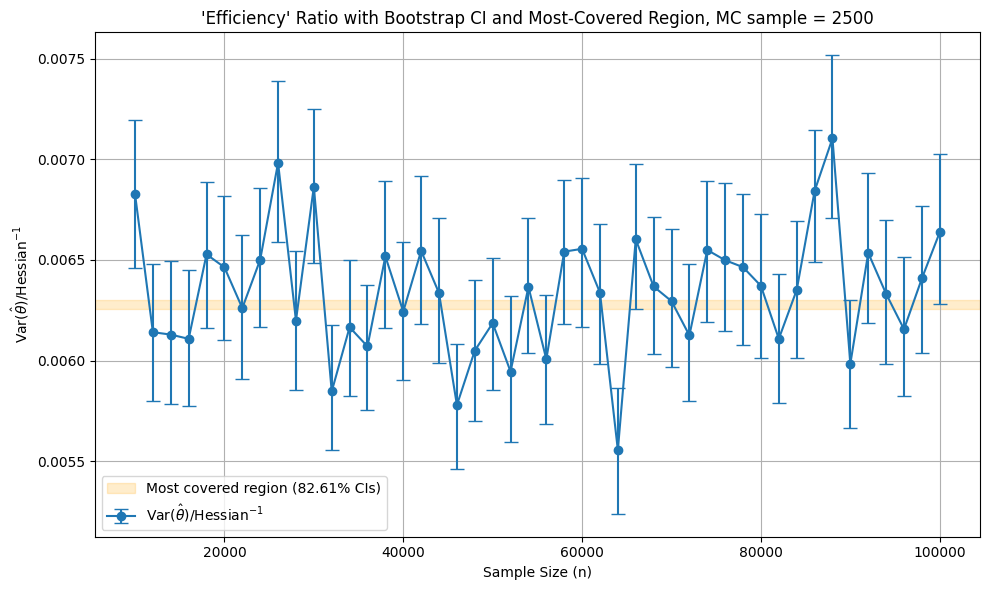

In [19]:
# num_trials = 2500
# everything = penalty_reg_variance_simulation_custom(num_trials = num_trials, 
#                                       n_min = 10000, 
#                                       n_max = 100001, 
#                                       n_step_size = 2000)
# df_Op_2500 = everything[0]

df_Op_2500 = pd.read_csv(r"temp_df/df_Op_var_2500.csv")
plot_theta_var_ratio_with_ci(df = df_Op_2500, 
                             num_trials= 2500,
                             var_theta = "empirical_cov_diag",
                             var_theta_lb = "empirical_cov_CI_lb",
                             var_theta_ub = "empirical_cov_CI_ub",
                             hessian_theta_inv = "inv_Curved_FI_diag",
                             n = 'n')

In [21]:
def penalty_reg_variance_simulation_custom_direct(num_trials, n_min, n_max, n_step_size, sigma=0.02, p=2):
    assert p == 2, "GaussianPenaltyLoss2D currently supports only p=2 (rotation matrix case)"

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    var_list = []
    alpha = torch.tensor([[10, 1, 1], [1, 10, 1]], dtype= torch.float64)
    dir = Dirichlet(alpha)
    K, p_temp = alpha.shape
    

    for n in range(n_min, n_max, n_step_size):
        X = dir.sample((n // K,)).transpose(0, 1).reshape(n, p_temp)[:, :2].to(device)

        # Use current V = identity (true value)
        V = torch.eye(p, device=device)
        model_0 = GaussianPenaltyLoss2D(sigma=sigma, device=device)
        hessian_theta = model_0.d2theta_manual(X)

        theta_list = []

        for _ in range(num_trials):
            sys.stdout.write(f"\rCurrently at {((_+1) / num_trials * 100):.2f}% for n = {n}. ")
            sys.stdout.flush()
            Y = gen_Y(X, sigma).to(device)  # assumes true_W = I

            model = GaussianPenaltyLoss2D(sigma=sigma, device=device)
            
            model.optimize_theta_newton(Y, max_steps= 1000, tolerance = 1e-4)
            

            theta_list.append(model.theta.data.cpu().detach())
            
        theta_tensor = torch.tensor(theta_list, dtype=torch.float64)  # ensure float64 for precision
        theta_var = theta_tensor.var(unbiased=True)

        # Bootstrap for CI
        B = 1000
        theta_array = theta_tensor.numpy()
        n_samples = len(theta_array)
        boot_vars = []

        for _ in range(B):
            indices = np.random.choice(n_samples, size=n_samples, replace=True)
            sample = theta_array[indices]
            boot_var = np.var(sample, ddof=1)
            boot_vars.append(boot_var)

        lower = np.percentile(boot_vars, 2.5)
        upper = np.percentile(boot_vars, 97.5)

        inv_hessian = 1 / hessian_theta

        var_record = {
            "n": n,
            "theta_var": theta_var.item(),
            "theta_var_CI_lb": lower,
            "theta_var_CI_ub": upper,
            "inv_hessian": inv_hessian.item()
        }
        var_list.append(var_record)

    df = pd.DataFrame(var_list)
    return df

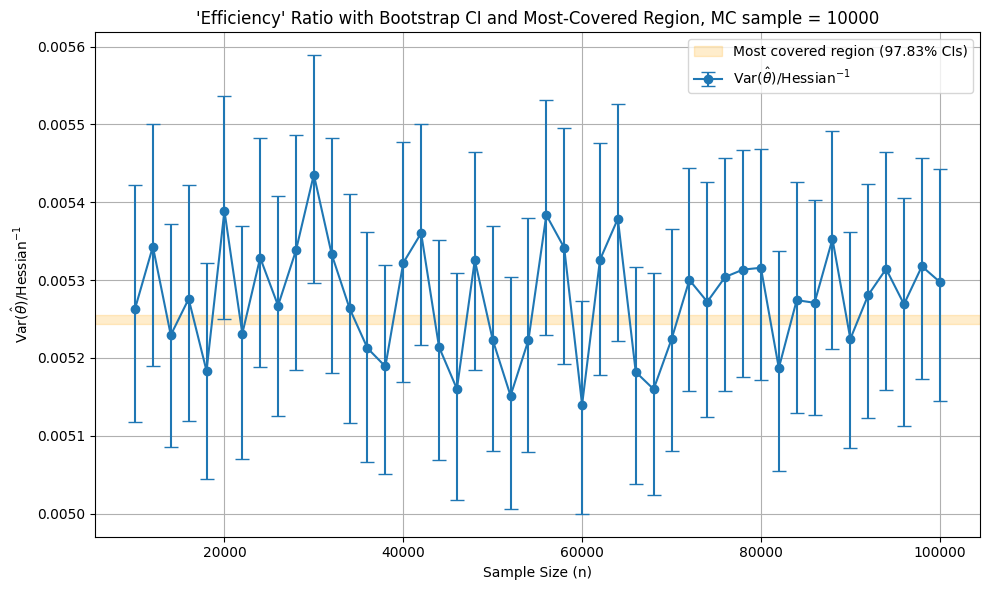

In [26]:
# num_trials = 10000
# df_Op_10000 = penalty_reg_variance_simulation_custom_direct(num_trials = num_trials, 
#                                       n_min = 10000, 
#                                       n_max = 100001, 
#                                       n_step_size = 2000)


df_Op_10000 = pd.read_csv(r"temp_df/df_Op_var_10000_direct.csv")
plot_theta_var_ratio_with_ci(df = df_Op_10000, 
                             num_trials= 10000,
                             var_theta = "theta_var",
                             var_theta_lb = "theta_var_CI_lb",
                             var_theta_ub = "theta_var_CI_ub",
                             hessian_theta_inv = "inv_hessian",
                             n = 'n')